# Accessibility-based characters

Linking points of interest and similar point-based data to enclosed tessellation using network accessibility approach.

For each enclosed tessellation cell, we want to know how many POIs are within 15 minutes walking distance (translated to 1200m). Furhtemore, we want to know how far is the closes one.

We use [`pandana`](http://udst.github.io/pandana/) package to generate accessibility characters. Pandana uses efficient [contraction hierarchies](https://en.wikipedia.org/wiki/Contraction_hierarchies) algorithm to measure the shortes path in a network. Therefore, we link each enclosed cell to a node of a network (the actual linking has been already done in [previous steps](morpohometrics)). Then we link each POI to a node of network and compute distances between nodes. Resulting values are then transferred from nodes back to tessellation. Note that all tessellation cells attached to a single node will share the same value.

In [1]:
import geopandas as gpd
import pandana
import pandas as pd
from shapely.geometry import box
from tqdm import tqdm
import pygeos

## Create network

Load both parts of street network, i.e. nodes and edges (output of `momepy.nx_to_gdf`).

In [2]:
edges = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/morphometrics/edges/edges_0.pq')
nodes = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/morphometrics/nodes/nodes_0.pq')

Create `pandana.Network` object. We already have all necessary in our two GeoDataFrames.

In [3]:
nodes = nodes.set_index('nodeID')

In [4]:
%%time
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

CPU times: user 4.84 s, sys: 137 ms, total: 4.98 s
Wall time: 407 ms


## Find nearest POIs

Load points of interest, clip the to the extent of the chunk, link to `network` and find nearest to each network node.

In [5]:
pois = pd.read_csv('../../urbangrammar_samba/functional_data/pois/GEOLYTIX - RetailPoints/geolytix_retailpoints_v17_202008.csv')

In [6]:
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois.bng_e, pois.bng_n), crs=27700)
pois = gpd.clip(pois, box(*nodes.total_bounds))

In [7]:
%%time
network.set_pois(category = 'supermarkets',
                 maxdist = 1200,
                 maxitems=100,
                 x_col = pois.bng_e, 
                 y_col = pois.bng_n)

CPU times: user 52.8 ms, sys: 8.15 ms, total: 61 ms
Wall time: 53.3 ms


In [10]:
%%time
results = network.nearest_pois(distance = 1200,
                               category = 'supermarkets',
                               num_pois = 100,
                               include_poi_ids = False)

CPU times: user 3.01 s, sys: 120 ms, total: 3.13 s
Wall time: 2.68 s


We are interested in a distance to the nearest (if wihtin 15 minutes threshold) and number of POIs within the threshold.

In [11]:
counts = results.replace(1200, pd.NA).count(axis=1)

In [13]:
nodes['food'] = counts

<AxesSubplot:>

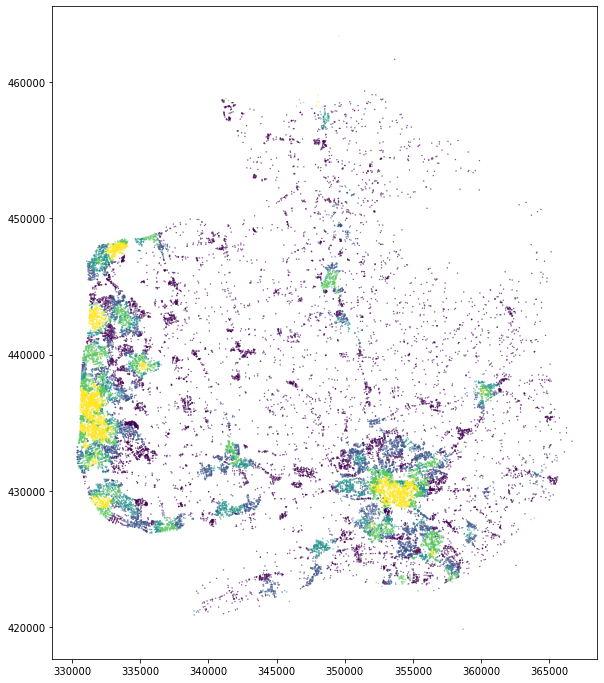

In [15]:
nodes.plot('food', figsize=(12, 12), markersize=(.1), scheme='quantiles')

In [18]:
min_distance = results.replace(1200, pd.NA).min(axis=1)

In [19]:
nodes['food_distance'] = min_distance

<AxesSubplot:>

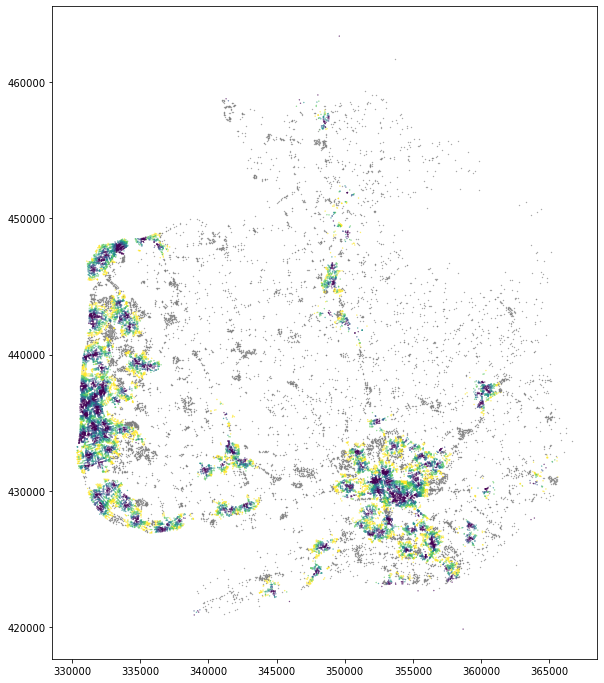

In [23]:
nodes.plot('food_distance', figsize=(12, 12), markersize=(.1), scheme='quantiles', missing_kwds={'color': 'grey', 'markersize': .1})

## Attach distant nodes
Some nodes are further away than 15 minutes from a POI, but we are intereseted how far they are. Therefore, we run pandana again, for a single item but a large distance ensuring each node gets attached.

In [11]:
%%time
network.set_pois(category = 'supermarkets',
                 maxdist = 50000,
                 maxitems=1,
                 x_col = pois.bng_e, 
                 y_col = pois.bng_n)

CPU times: user 50.4 ms, sys: 12.9 ms, total: 63.3 ms
Wall time: 56.2 ms


In [12]:
%%time
results = network.nearest_pois(distance = 50000,
                               category = 'supermarkets',
                               num_pois = 1,
                               include_poi_ids = False)

CPU times: user 2.28 s, sys: 33 ms, total: 2.31 s
Wall time: 151 ms


In [20]:
nodes['nearest'] = results[1].replace(50000, pd.NA)

<AxesSubplot:>

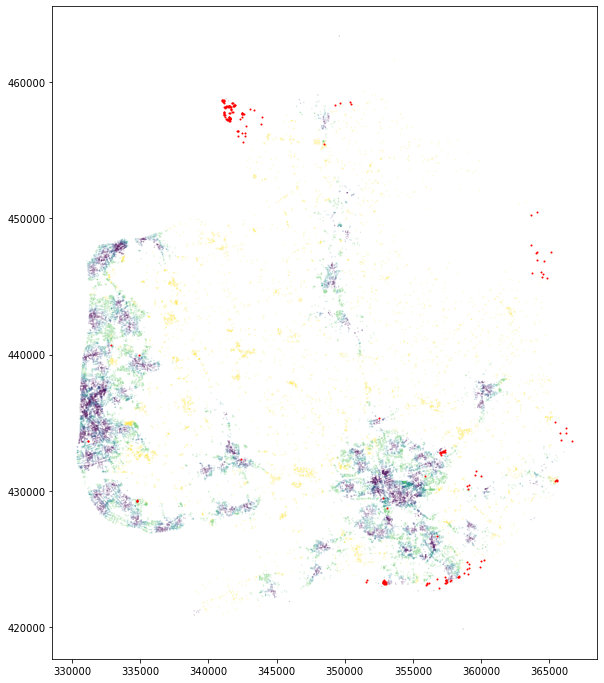

In [21]:
nodes.plot('nearest', figsize=(12, 12), markersize=(.01), scheme='quantiles', missing_kwds={'color': 'red', 'markersize': 1})

Although there are still some nodes which are not connected, that is likely due to disconections of the network.

## Measure accessiblity characters

Now, we measure accessibility to:

- supermarkets (using Geolytix data)
- listed buildings
- FHRS points
- cultural venues

Cultural venues are often both points and polygons, therefore we remove duplicates.

Pandana is multi-threaded, therefore we do not need to use `dask` to parallelise the operation on a single machine. It is also a memory-heavy operation, so we would not fit with multiple processes anyway.

In [23]:
supermarkets = pd.read_csv('../../urbangrammar_samba/functional_data/pois/GEOLYTIX - RetailPoints/geolytix_retailpoints_v17_202008.csv')
listed = gpd.read_parquet('../../urbangrammar_samba/functional_data/pois/listed_buildings/listed_buildings_gb.pq')
fhrs = pd.read_csv('../../urbangrammar_samba/functional_data/fhrs/Data/fhrs_location_20200528.csv')
culture = gpd.read_parquet('../../urbangrammar_samba/functional_data/pois/culture_gb.pq')

supermarkets = gpd.GeoDataFrame(supermarkets, geometry=gpd.points_from_xy(supermarkets.bng_e, supermarkets.bng_n), crs=27700)
fhrs = gpd.GeoDataFrame(fhrs, geometry=gpd.points_from_xy(fhrs.bng_east, fhrs.bng_north), crs=27700)

culture = culture.reset_index(drop=True)
inp, res = pygeos.STRtree(culture.geometry.values.data).query_bulk(culture.geometry.values.data, predicate='contains_properly')
culture = culture.drop(inp)
culture.geometry = culture.centroid

ValueError: Predicate contains_properly is not valid; must be one of within, touches, overlaps, intersects, crosses, contains

In [ ]:
for c in tqdm(range(103), total=103):
    nodes = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/nodes/nodes_{c}.pq')
    edges = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/edges/edges_{c}.pq')
    nodes = nodes.set_index('nodeID')
    network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])
    network.precompute(1200)

    supermarkets_c = gpd.clip(supermarkets, box(*nodes.total_bounds))
    network.set_pois(category = 'supermarkets',
                     maxdist = 1200,
                     maxitems=1000,
                     x_col = supermarkets_c.bng_e, 
                     y_col = supermarkets_c.bng_n)

    res = network.nearest_pois(distance = 1200,
                               category = 'supermarkets',
                               num_pois = 1000 if len(supermarkets_c) > 1000 else len(supermarkets_c),
                               include_poi_ids = False)
    
    res = res.replace(1200, pd.NA)
    nodes['supermarkets_nearest'] = res.min(axis=1)
    nodes['supermarkets_counts'] = res.count(axis=1)

    listed_c = gpd.clip(listed, box(*nodes.total_bounds)).explode()
    network.set_pois(category = 'listed',
                     maxdist = 1200,
                     maxitems=10000,
                     x_col = listed_c.geometry.x, 
                     y_col = listed_c.geometry.y)

    res = network.nearest_pois(distance = 1200,
                               category = 'listed',
                               num_pois = 10000 if len(listed_c) > 10000 else len(listed_c),
                               include_poi_ids = False)
    
    res = res.replace(1200, pd.NA)
    nodes['listed_nearest'] = res.min(axis=1)
    nodes['listed_counts'] = res.count(axis=1)


    fhrs_c = gpd.clip(fhrs, box(*nodes.total_bounds))
    network.set_pois(category = 'fhrs',
                     maxdist = 1200,
                     maxitems=10000,
                     x_col = fhrs_c.bng_east, 
                     y_col = fhrs_c.bng_north)

    res = network.nearest_pois(distance = 1200,
                               category = 'fhrs',
                               num_pois = 10000 if len(fhrs_c) > 10000 else len(fhrs_c),
                               include_poi_ids = False)

    res = res.replace(1200, pd.NA)
    nodes['fhrs_nearest'] = res.min(axis=1)
    nodes['fhrs_counts'] = res.count(axis=1)

    culture_c = gpd.clip(culture, box(*nodes.total_bounds))
    network.set_pois(category = 'culture',
                     maxdist = 1200,
                     maxitems=500,
                     x_col = culture_c.geometry.x, 
                     y_col = culture_c.geometry.y)

    res = network.nearest_pois(distance = 1200,
                               category = 'culture',
                               num_pois = 500 if len(culture_c) > 500 else len(culture_c),
                               include_poi_ids = False)

    res = res.replace(1200, pd.NA)
    nodes['culture_nearest'] = res.min(axis=1)
    nodes['culture_counts'] = res.count(axis=1)

    cells = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_{c}.pq')
    cells = cells.merge(nodes, on='nodeID', how='left')
    cells[['hindex', 'supermarkets_nearest', 'supermarkets_counts',
           'listed_nearest', 'listed_counts', 'fhrs_nearest',
           'fhrs_counts', 'culture_nearest', 'culture_counts'
          ]
         ].to_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/accessibility/access_{c}.pq")

## Attach missing

In [22]:
for c in tqdm(range(103), total=103):
    nodes = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/nodes/nodes_{c}.pq')
    edges = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/edges/edges_{c}.pq')
    nodes = nodes.set_index('nodeID')
    network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])
    network.precompute(50000)

    supermarkets_c = gpd.clip(supermarkets, box(*nodes.total_bounds))
    network.set_pois(category = 'supermarkets',
                     maxdist = 50000,
                     maxitems=1,
                     x_col = supermarkets_c.bng_e, 
                     y_col = supermarkets_c.bng_n)

    res = network.nearest_pois(distance = 50000,
                               category = 'supermarkets',
                               num_pois = 1,
                               include_poi_ids = False)
    
    nodes['supermarkets_nearest'] = res[1].replace(50000, pd.NA)

    listed_c = gpd.clip(listed, box(*nodes.total_bounds)).explode()
    network.set_pois(category = 'listed',
                     maxdist = 50000,
                     maxitems=1,
                     x_col = listed_c.geometry.x, 
                     y_col = listed_c.geometry.y)

    res = network.nearest_pois(distance = 50000,
                               category = 'listed',
                               num_pois = 1,
                               include_poi_ids = False)
    
    nodes['listed_nearest'] = res[1].replace(50000, pd.NA)


    fhrs_c = gpd.clip(fhrs, box(*nodes.total_bounds))
    network.set_pois(category = 'fhrs',
                     maxdist = 50000,
                     maxitems=1,
                     x_col = fhrs_c.bng_east, 
                     y_col = fhrs_c.bng_north)

    res = network.nearest_pois(distance = 50000,
                               category = 'fhrs',
                               num_pois = 1,
                               include_poi_ids = False)

    nodes['fhrs_nearest'] = res[1].replace(50000, pd.NA)

    culture_c = gpd.clip(culture, box(*nodes.total_bounds))
    network.set_pois(category = 'culture',
                     maxdist = 50000,
                     maxitems=1,
                     x_col = culture_c.geometry.x, 
                     y_col = culture_c.geometry.y)

    res = network.nearest_pois(distance = 50000,
                               category = 'culture',
                               num_pois = 1,
                               include_poi_ids = False)

    nodes['culture_nearest'] = res[1].replace(50000, pd.NA)

    cells = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_{c}.pq')
    break
    
    cells = cells.merge(nodes, on='nodeID', how='left')
    cells[['hindex', 'supermarkets_nearest', 'supermarkets_counts',
           'listed_nearest', 'listed_counts', 'fhrs_nearest',
           'fhrs_counts', 'culture_nearest', 'culture_counts'
          ]
         ].to_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/accessibility/access_{c}.pq")

  0%|          | 0/103 [00:07<?, ?it/s]


NameError: name 'supermarkets' is not defined

In [24]:
pygeos.__version__

'0.7.1'